# 4.2 時系列のシミュレーションの特殊性

## 4.2.1 自分で作業を行う

とある団体に所属する会員による寄付の時系列データを作成。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

以下の規則や仮定を組み込んだ変数を用意。

- 特定の確立に従って入会年が決定される
- 入会年と会員ステータスは完全に独立
  - 現実世界では2変数には何らかの関連があるはずだが今回は考慮していない

In [2]:
years = ['2014', '2015', '2016', '2017', '2018']
userStatus = ['bronze', 'silver', 'gold', 'inactive']

userYears = np.random.choice(years, 1000, p=[0.1, 0.1, 0.15, 0.30, 0.35])
userStats = np.random.choice(userStatus, 1000, p=[0.5, 0.3, 0.1, 0.1])
yearJoined = pd.DataFrame({'yearJoined': userYears, 'userStats': userStats})

所属団体の挙動を以下の様に定義。

- 毎週3通のメールを会員に送る

会員のメールに対する反応を以下の様に定義。

- メールを一切開かない
- 関与レベル（メール開封率）が一定
  - メールを開封した回数は、2項分布に従う。
  - 2項分布の確率`p`は0以上1以下の一様分布によって決定される。
- 関与レベルが増加もしくは減少している
  - 一様分布から生成された乱数によって、2項分布のパラメータ`p`を増加/減少させる。
  
※ 書籍において`p = max(min(1, p * fac), 0)`の順序が間違っていたため修正。

In [3]:
NUM_EMAILS_SENT_WEEKLY = 3

def never_opens(period_rng):
    return []


def constant_open_rate(period_rng):
    n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0, 1)
    num_opened = np.random.binomial(n, p, len(period_rng))
    return num_opened


def increasing_open_rate(period_rng):
    return open_rate_with_factor_change(period_rng, np.random.uniform(1.01, 1.30))


def decreasing_open_rate(period_rng):
    return open_rate_with_factor_change(period_rng, np.random.uniform(0.5, 0.99))


def open_rate_with_factor_change(period_rng, fac):
    if len(period_rng) < 1:
        return []
    times = np.random.randint(0, len(period_rng), int(0.1 * len(period_rng)))
    num_opened = np.zeros(len(period_rng))

    for prd in range(0, len(period_rng), 2):
        try:
            n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0, 1)
            p = max(min(1, p * fac), 0)
            num_opened[prd:(prd+2)] = np.random.binomial(n, p, 2)
        except:
            num_opened[prd] = np.random.binomial(n, p, 1)

    for t in range(len(times)):
        num_opened[times[t]] = 0

    return num_opened

送信した全メールの中で開封した割合の分だけ所持金を寄付可能額として寄付金額を選択肢から選ぶという規則を設ける。

会員として過ごした年数に$\lambda=2$のポアソン分布から得られる値を掛けた値を寄付回数とする。

In [4]:
def produce_donations(period_rng, user_behavior,
                      num_emails, use_id, user_join_year):

    donation_amounts = np.array([0, 25, 50, 75, 100, 250, 500, 1000, 1500, 2000])
    user_has = np.random.choice(donation_amounts)
    email_fraction = num_emails / (NUM_EMAILS_SENT_WEEKLY * len(period_rng))

    user_gives = user_has * email_fraction
    user_gives_idx = np.where(user_gives >= donation_amounts)[0][-1]
    user_gives_idx = max(min(user_gives_idx, len(donation_amounts) - 2), 1)
    num_times_gave = np.random.poisson(2) * (2018 - user_join_year)
    times = np.random.randint(0, len(period_rng), num_times_gave)
    dons = pd.DataFrame({'user': [], 'amount': [], 'timestamp': []})

    for n in range(num_times_gave):
        donation = donation_amounts[user_gives_idx + np.random.binomial(1, .3)]
        ts = str(period_rng[times[n]].start_time + random_weekly_time_delta())
        dons = dons.append(pd.DataFrame({'user': [use_id], 'amount': [donation],
                                         'timestamp': [ts]}))

    if dons.shape[0] > 0:
        dons = dons[dons.amount != 0]
    return dons

寄付した曜日と時刻を決める条件として、11時から23時を採用することでタイムゾーンの近い寄付者が日中帯に寄付している様子を再現。

In [5]:
def random_weekly_time_delta():
    days_of_week = [d for d in range(7)]
    hours_of_day = [h for h in range(11, 23)]
    minute_of_hour = [m for m in range(60)]
    second_of_minute = [s for s in range(60)]
    return (
        pd.Timedelta(str(np.random.choice(days_of_week)) + " days")
        + pd.Timedelta(str(np.random.choice(hours_of_day)) + " hours")
        + pd.Timedelta(str(np.random.choice(minute_of_hour)) + " minutes")
        + pd.Timedelta(str(np.random.choice(second_of_minute)) + " seconds")
    )

In [6]:
behaviors = [
    never_opens,
    constant_open_rate,
    increasing_open_rate,
    decreasing_open_rate,
]

member_behaviors = np.random.choice(behaviors, 1000, [0.2, 0.5, 0.1, 0.2])
rng = pd.period_range("2015-02-14", "2018-06-01", freq="W")
emails = pd.DataFrame({"member": [], "week": [], "emailsOpened": []})
donations = pd.DataFrame({"user": [], "amount": [], "timestamp": []})

for idx in range(yearJoined.shape[0]):
    join_date = pd.Timestamp(yearJoined.iloc[idx].yearJoined) \
        + pd.Timedelta(str(np.random.randint(0, 365)) + " days")
    join_date = min(join_date, pd.Timestamp("2018-06-01"))

    member_rng = rng[rng.start_time > join_date]

    if len(member_rng) < 1:
        continue

    info = member_behaviors[idx](member_rng)
    if len(info) == len(member_rng):
        emails = emails.append(
            pd.DataFrame({
                "member": [idx] * len(info),
                "week": [str(r.start_time) for r in member_rng],
                "emailsOpened": info}))
        donations = donations.append(
            produce_donations(member_rng, member_behaviors[idx], sum(info), idx,
                              join_date.year))

各月に受け取った寄付総額をプロットすることで、現在の条件における寄付の時間的挙動を調べる。

生成された会員は20%の確率でメール開封率が減少していく性質を持った会員となるが、会員が退会した場合の規定が用意されていない。

よって、メール開封率が影響する寄付金額についても増加トレンドがみられるのは当然。

※ 書籍において`df`と`donations`を書き間違えているため修正。

,user,amount,timestamp
timestamp,,,
2015-02-09 14:03:07,580.0,25.0,2015-02-09 14:03:07
2015-02-09 15:07:25,265.0,75.0,2015-02-09 15:07:25
2015-02-10 12:16:01,390.0,25.0,2015-02-10 12:16:01
2015-02-11 20:02:29,750.0,25.0,2015-02-11 20:02:29
2015-02-12 15:01:44,928.0,1000.0,2015-02-12 15:01:44
...,...,...,...
2018-05-31 12:52:13,42.0,100.0,2018-05-31 12:52:13
2018-06-01 16:00:51,297.0,25.0,2018-06-01 16:00:51
2018-06-01 20:12:54,311.0,25.0,2018-06-01 20:12:54


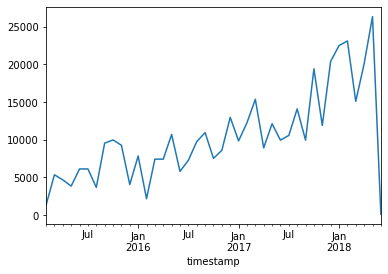

In [7]:
donations.set_index(pd.to_datetime(donations.timestamp), inplace=True)
donations.sort_index(inplace=True)
donations.groupby(pd.Grouper(freq='M')).amount.sum().plot()

donations

参考として`emails`も同様の可視化を実施。

,member,week,emailsOpened
week,,,
2015-02-09,81.0,2015-02-09 00:00:00,0.0
2015-02-09,794.0,2015-02-09 00:00:00,1.0
2015-02-09,683.0,2015-02-09 00:00:00,2.0
2015-02-09,925.0,2015-02-09 00:00:00,1.0
2015-02-09,450.0,2015-02-09 00:00:00,1.0
...,...,...,...
2018-05-28,304.0,2018-05-28 00:00:00,2.0
2018-05-28,305.0,2018-05-28 00:00:00,3.0
2018-05-28,306.0,2018-05-28 00:00:00,2.0


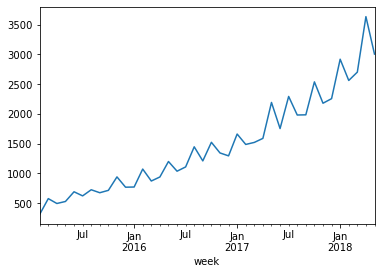

In [8]:
emails.set_index(pd.to_datetime(emails.week), inplace=True)
emails.sort_index(inplace=True)
emails.groupby(pd.Grouper(freq='M')).emailsOpened.sum().plot()

emails

## 4.2.2 自動で走るシミュレーション世界を構築する

とあるタクシー会社に所属しておりシフトが様々な車両の全体としての挙動を予測する。

タクシー識別番号の取得関数。

In [9]:
def taxi_id_number(num_taxis):
    arr = np.arange(num_taxis)
    np.random.shuffle(arr)

    for i in range(num_taxis):
        yield arr[i]

Pythonのジェネレータに慣れていない人向けの動作確認コード。

10回以上呼び出すと`StopIteration`例外を出す。

In [10]:
ids = taxi_id_number(10)
print(next(ids))
print(next(ids))
print(next(ids))

3
6
1


シフト開始時間、シフト終了時間（開始から7.5時間）、平均乗車回数のジェネレータを返す関数。

平均乗車回数はシフトに依存するという規定。

In [11]:
def shift_info():
    start_times_and_freqs = [(0, 8), (8, 30), (16, 15)]
    indices = np.arange(len(start_times_and_freqs))

    while True:
        idx = np.random.choice(indices, p=[0.25, 0.5, 0.25])
        start = start_times_and_freqs[idx]
        yield (start[0], start[0] + 7.5, start[1])

[dataclasses](https://docs.python.org/3/library/dataclasses.html)を用いることで、`__init__()`の省略を行っておく。

In [12]:
from dataclasses import dataclass


@dataclass
class TimePoint:
    taxi_id: int
    name: str
    time: float

    def __lt__(self, other):
        return self.time < other.time

    def __str__(self):
        hour, minute = divmod(self.time * 60, 60)
        clock = f"{hour:02.0f}:{minute:02.0f}"
        return f"id: {self.taxi_id:04d}\tname: {self.name}\ttime: {clock}"

$\mu=平均乗車回数, \sigma=2$のパラメータを持つ正規分布から得た乱数を整数に丸めて実乗車回数とする。

シフトを開始してから顧客の乗車および降車というイベントが発生するまでの時間はポアソン分布から取得される。

確率的に決定した実乗車回数が終了したのち、シフトが終わるまでの時間も同様にポアソン分布から取得される。

In [13]:
def taxi_process(taxi_id_generator, shift_info_generator):
    taxi_id = next(taxi_id_generator)
    shift_start, shift_end, shift_mean_trips = next(shift_info_generator)
    actual_trips = round(np.random.normal(loc=shift_mean_trips, scale=2))
    average_trip_time = 6.5 / shift_mean_trips * 60
    between_events_time = 1.0 / (shift_mean_trips - 1) * 60
    time = shift_start
    
    yield TimePoint(taxi_id, "start shift", time)

    deltaT = np.random.poisson(between_events_time) / 60
    time += deltaT

    for i in range(actual_trips):
        yield TimePoint(taxi_id, "pick up", time)

        deltaT = np.random.poisson(average_trip_time) / 60
        time += deltaT
        yield TimePoint(taxi_id, "drop off", time)

        deltaT = np.random.poisson(between_events_time) / 60
        time += deltaT

    deltaT = np.random.poisson(between_events_time) / 60
    time += deltaT
    yield TimePoint(taxi_id, "end shift", time)

各タクシーの下記イベントが発生する度に`TimePoint`が優先度付きキューに追加される。

- シフト開始
- 顧客乗車
- 顧客降車
- シフト終了


小さい`time`を持つ`TimePoint`から順にキューからプリントされることで、ログが出来上がる

In [14]:
import queue


class Simulator:
    def __init__(self, num_taxis):
        self._time_points = queue.PriorityQueue()
        taxi_id_generator = taxi_id_number(num_taxis)
        shift_info_generator = shift_info()
        self._taxis = [
            taxi_process(taxi_id_generator, shift_info_generator)
            for i in range(num_taxis)]
        self._prepare_run()

    def _prepare_run(self):
        for t in self._taxis:
            while True:
                try:
                    e = next(t)
                    self._time_points.put(e)
                except StopIteration:
                    break

    def run(self):
        sim_time = 0
        while sim_time < 24:
            if self._time_points.empty():
                break

            p = self._time_points.get()
            sim_time = p.time
            print(p)


sim = Simulator(10)
sim.run()

id: 0005	name: start shift	time: 00:00
id: 0005	name: pick up	time: 00:05
id: 0005	name: drop off	time: 00:53
id: 0005	name: pick up	time: 01:01
id: 0005	name: drop off	time: 01:48
id: 0005	name: pick up	time: 02:00
id: 0005	name: drop off	time: 02:49
id: 0005	name: pick up	time: 03:00
id: 0005	name: drop off	time: 04:00
id: 0005	name: pick up	time: 04:06
id: 0005	name: drop off	time: 04:42
id: 0005	name: pick up	time: 04:49
id: 0005	name: drop off	time: 05:38
id: 0005	name: pick up	time: 05:48
id: 0005	name: drop off	time: 06:42
id: 0005	name: pick up	time: 06:54
id: 0005	name: drop off	time: 07:38
id: 0005	name: end shift	time: 07:58
id: 0008	name: start shift	time: 08:00
id: 0006	name: start shift	time: 08:00
id: 0009	name: start shift	time: 08:00
id: 0003	name: start shift	time: 08:00
id: 0002	name: start shift	time: 08:00
id: 0000	name: start shift	time: 08:00
id: 0004	name: start shift	time: 08:00
id: 0006	name: pick up	time: 08:01
id: 0003	name: pick up	time: 08:01
id: 0002	name

## 4.2.3 物理シミュレーション

常磁性体が時間経過とともにより安定な強磁性体へと遷移していく様子をシミュレーションしていく。

格子の幅/高さ、温度、ベータといったシミュレーションに必要な情報を定義。

In [15]:
N = 5
M = 5

temperature = 0.5
BETA = 1 / temperature

格子サイズから、初期状態をランダムに決定する関数。

In [16]:
def initRandState(N, M):
    block = np.random.choice([-1, 1], size=(N, M))
    return block

指定した格子点のスピンが反転するのに必要なエネルギーを、当該格子の周囲の格子のスピンから算出。

In [17]:
def costForCenterState(state, i, j, n, m):
    centerS = state[i, j]
    neighbors = [((i + 1) % n, j), ((i - 1) % n, j),
                 (i, (j + 1) % m), (i, (j - 1) % m)]
    interactionE = [state[x, y] * centerS for (x, y) in neighbors]
    return np.sum(interactionE)

格子全体の磁力の強さと向きを計算する関数。

In [18]:
def magnetizationForState(state):
    return np.sum(state)

現在の状態から次の状態のシミュレーションを行う関数。

スピンに必要なエネルギーが0未満のとき、スピンは反転する。

スピンに必要なエネルギーが0以上であっても、スピンに必要なエネルギーが小さいほど、また温度が高いほどスピンが反転しやすくなる。

In [19]:
def mcmcAdjust(state):
    n = state.shape[0]
    m = state.shape[1]
    x, y = np.random.randint(0, n), np.random.randint(0, m)
    centerS = state[x, y]
    cost = costForCenterState(state, x, y, n, m)

    if cost < 0:
        centerS *= -1
    elif np.random.random() < np.exp(-cost * BETA):
        centerS *= -1
    state[x, y] = centerS
    return state

シミュレーションを実行する役割と、格子全体の磁力の強さおよび向きのログを記録する関数。

シミュレーションのステップ数が格子数の100倍以上のとき、格子の状態の途中経過も記録される。

In [20]:
def runState(state, n_steps, snapsteps=None):
    if snapsteps is None:
        snapsteps = np.linspace(
            0, n_steps, num=round(n_steps / (M * N * 100)), dtype=np.int32)

    saved_states = []
    sp = 0
    magnet_hist = []

    for i in range(n_steps):
        state = mcmcAdjust(state)
        magnet_hist.append(magnetizationForState(state))

        if sp < len(snapsteps) and i == snapsteps[sp]:
            saved_states.append(np.copy(state))
            sp += 1

    return state, saved_states, magnet_hist

シミュレーションを実行。

In [21]:
init_state = initRandState(N, M)
print(init_state)
final_state = runState(np.copy(init_state), 1000)

[[-1 -1 -1  1 -1]
 [ 1  1  1  1  1]
 [-1  1 -1 -1  1]
 [ 1 -1 -1  1 -1]
 [-1 -1 -1 -1  1]]


上のセルで出力した格子の初期状態マトリックスを画像で表示。

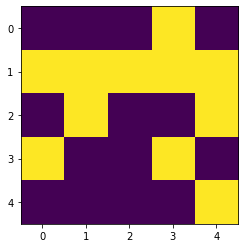

In [22]:
plt.imshow(init_state)
plt.show()

時間の経過とともにスピンの向きが$+1$または$-1$方向に揃っていくため、$5 \times 5$の格子点のスピンの向きの合計値は、$+25$または$-25$に収束する。

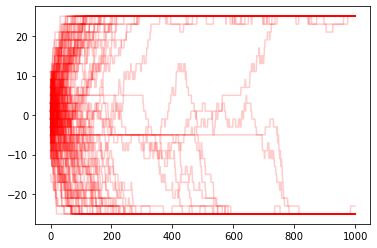

In [23]:
results = []

for i in range(100):
    init_state = initRandState(N, M)
    final_state, states, magnet_hist = runState(init_state, 1000)
    results.append(magnet_hist)

for mh in results:
    plt.plot(mh, "r", alpha=0.2)

シミュレーションデータは以下のような目的で利用することが出来る。

- 実測データの取得環境が整うのに先立って、シミュレーションデータで機械学習パイプライン構築を始められる＆有効性を事前検証できる
- シミュレーション動画を見ることで系に関する洞察を得る